# Imports

In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})
# import matplotlib.pylab as pl
from matplotlib import cm
from functions.data import add_attributes

# Data
### Pick a specific expiration

In [2]:
all_data = pd.read_hdf(os.path.join("..", "processed_data", "spx_iv_db.h5"))
exp_date = "2017-12-15"
df = all_data[all_data["EXP"]==exp_date].dropna().reset_index(drop=True)
df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA
0,2017-07-03,2017-12-15,2425,C,74.4,75.350,76.30,11,15111,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1167,0.1182,0.1196,0.0878,0.5625,0.0028,-0.2181,6.4220
1,2017-07-03,2017-12-15,2425,P,77.7,78.600,79.50,25,13822,2429.01,4.01,0,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1168,0.1182,0.1196,0.1350,-0.4489,0.0018,-0.2230,6.4486
2,2017-07-03,2017-12-15,2450,P,87.8,88.750,89.70,0,5926,2429.01,20.99,1,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1114,0.1128,0.1143,0.1312,-0.4948,0.0019,-0.2133,6.5015
3,2017-07-03,2017-12-15,2450,C,59.8,60.700,61.60,7,19022,2429.01,20.99,1,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1115,0.1129,0.1143,0.0878,0.4933,0.0028,-0.2146,6.5012
4,2017-07-03,2017-12-15,2400,P,68.9,69.800,70.70,501,32564,2429.01,29.01,2,116,165,0.0148,0.0148,0.0152,0.0152,2421.7557,2421.7434,2421.7357,2421.7474,0.0148,2421.7434,0.1223,0.1237,0.1251,0.1393,-0.4058,0.0017,-0.2300,6.3201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15278,2017-12-14,2017-12-15,2540,P,0.1,0.200,0.30,20,31619,2652.06,112.06,44,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.2825,0.3077,0.3253,0.1294,0.0000,0.0000,0.0000,0.0000
15279,2017-12-14,2017-12-15,2535,P,0.1,0.200,0.30,73,15733,2652.06,117.06,46,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.2936,0.3197,0.3378,0.1294,0.0000,0.0000,0.0000,0.0000
15280,2017-12-14,2017-12-15,2530,P,0.1,0.200,0.30,16,15516,2652.06,122.06,48,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3048,0.3316,0.3502,0.1294,0.0000,0.0000,0.0000,0.0000
15281,2017-12-14,2017-12-15,2525,P,0.1,0.200,0.30,1147,67725,2652.06,127.06,50,1,1,0.2687,-0.0306,0.3629,0.4772,2654.2863,2654.3611,2654.3095,2654.3193,-0.0306,2654.3611,0.3159,0.3435,0.3627,0.1294,0.0000,0.0000,0.0000,0.0000


In [3]:
# Add ATM_VOLS

ATM_vols = df[df["RANK"]==0]
df = pd.merge(df, ATM_vols[["TS", "TYPE", "IV_BID", "IV_ASK"]], left_on=["TS", "TYPE"], right_on=["TS", "TYPE"], 
              suffixes=(None, "_ATM"), how="left")

# Add useful columns
df["MONEYNESS"] = df["UNDERLYING_PRICE"] - df["STRIKE"]

df["MONEYNESS_F"] = df["STRIKE"]/df["F_T"]
df["LOG_MONEYNESS_F"] = np.log(df["MONEYNESS_F"])
df["LOG_MONEYNESS_F_STANDARD_TIME"] = df["LOG_MONEYNESS_F"] / np.sqrt(df["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

df["IV_BID_DIFF"] = df["IV_BID"] - df["IV_BID_ATM"]
df["IV_ASK_DIFF"] = df["IV_ASK"] - df["IV_ASK_ATM"]

df["IV_BID_RATIO"] = df["IV_BID"]/df["IV_BID_ATM"]
df["IV_ASK_RATIO"] = df["IV_ASK"]/df["IV_ASK_ATM"]

# Parameters
fit_data = pd.read_excel(os.path.join("..", "processed_data", "iv_parameter.xlsx"), sheet_name=exp_date, index_col=0)

# Features

## Calculate features

In [4]:
def feature_avg(df, columns, weight=False):
    if not weight:
        features = df[columns].mean()
        return features
    
    else:
        wt = df[weight]
        features = df[columns].T @ wt / wt.sum()
        return features

In [5]:
feat = df.groupby("TS").apply(feature_avg, columns=["DELTA", "GAMMA", "THETA", "VEGA"], weight="VOLUME")
feat

,DELTA,GAMMA,THETA,VEGA
TS,,,,
2017-07-03,-0.1779,0.0014,-0.1886,4.9705
2017-07-05,0.0266,0.0017,-0.1610,4.7734
2017-07-06,0.0230,0.0018,-0.1742,4.9694
2017-07-07,-0.0915,0.0015,-0.1556,4.3166
2017-07-10,0.0263,0.0019,-0.1719,5.0678
...,...,...,...,...
2017-12-08,0.0878,0.0088,-0.3870,0.7160
2017-12-11,0.1252,0.0107,-0.6792,0.5559
2017-12-12,0.1755,0.0127,-0.9468,0.4996


In [6]:
def feature_cross_corr(features, parameters=fit_data):
    f_col = features.columns
    p_col = parameters.columns
    features = features.reset_index()
    parameters = parameters.shift(-1).reset_index().rename(columns={"index":"TS"})
    new_data = pd.merge(features, parameters,on="TS", how="left")
    new_data = new_data.dropna().set_index("TS")
    return new_data.corr().loc[f_col, p_col]

In [7]:
feature_cross_corr(feat)

,a,b,c,d,e
DELTA,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA,-0.5462,-0.5293,0.6480,-0.3459,0.5461


In [8]:
feat = df.groupby("TS").apply(feature_avg, columns=["DELTA", "GAMMA", "THETA", "VEGA"], weight="OPEN_INT")
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA,0.6497,0.4591,-0.8037,0.2617,-0.4774
THETA,-0.2653,-0.4874,0.2624,-0.3870,0.4991
VEGA,-0.5390,-0.4869,0.8529,-0.3004,0.5056


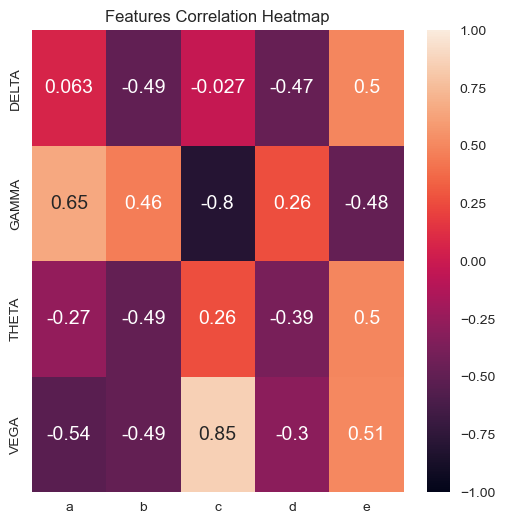

In [9]:
plt.figure(figsize=(6, 6))
heatmap1 = sns.heatmap(feat_corr, vmax=1, vmin=-1, annot=True)
heatmap1.set_title('Features Correlation Heatmap');

## Collect features

In [10]:
df["V_CLOSE"] = df["VOLUME"] * df["MID_CLOSE"]
df["V_IV"] = df["VOLUME"] * df["IMP_VOLATILITY"]
feat = df.groupby("TS").apply(feature_avg, columns=["DELTA", "GAMMA", "THETA", "VEGA"])
feat = feat.rename(columns={"DELTA":"DELTA_", "GAMMA":"GAMMA_", "THETA":"THETA_", "VEGA":"VEGA_"})

for weight in ["VOLUME", "OPEN_INT", "V_CLOSE", "V_IV"]:
    feat_data = df.groupby("TS").apply(feature_avg, columns=["DELTA", "GAMMA", "THETA", "VEGA"], weight=weight)
    name_dict = {}
    
    for each in feat_data.columns:
        name_dict[each] = each + "_" + weight
    
    feat_data = feat_data.rename(columns=name_dict)
    feat = feat.join(feat_data)

In [11]:
feat

,DELTA_,GAMMA_,THETA_,VEGA_,DELTA_VOLUME,GAMMA_VOLUME,THETA_VOLUME,VEGA_VOLUME,DELTA_OPEN_INT,GAMMA_OPEN_INT,THETA_OPEN_INT,VEGA_OPEN_INT,DELTA_V_CLOSE,GAMMA_V_CLOSE,THETA_V_CLOSE,VEGA_V_CLOSE,DELTA_V_IV,GAMMA_V_IV,THETA_V_IV,VEGA_V_IV
TS,,,,,,,,,,,,,,,,,,,,
2017-07-03,0.1406,0.0012,-0.1303,3.5146,-0.1779,0.0014,-0.1886,4.9705,0.1920,0.0013,-0.1408,3.6809,-0.0899,0.0016,-0.2079,5.3699,-0.2224,0.0015,-0.1987,5.2157
2017-07-05,0.1344,0.0013,-0.1257,3.4989,0.0266,0.0017,-0.1610,4.7734,0.2008,0.0013,-0.1331,3.5714,-0.0352,0.0018,-0.1799,5.2841,-0.0260,0.0016,-0.1580,4.6213
2017-07-06,0.1353,0.0013,-0.1320,3.5283,0.0230,0.0018,-0.1742,4.9694,0.1687,0.0013,-0.1438,3.7262,-0.0332,0.0020,-0.2022,5.7040,-0.0408,0.0017,-0.1754,4.9289
2017-07-07,0.1525,0.0012,-0.1286,3.4117,-0.0915,0.0015,-0.1556,4.3166,0.1875,0.0013,-0.1394,3.6069,-0.1602,0.0015,-0.1823,4.8954,-0.1320,0.0014,-0.1573,4.2708
2017-07-10,0.1396,0.0012,-0.1123,3.3124,0.0263,0.0019,-0.1719,5.0678,0.1789,0.0013,-0.1247,3.5555,-0.0429,0.0021,-0.1965,5.6762,-0.0250,0.0018,-0.1743,5.0085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-08,0.0252,0.0036,-0.1640,0.2995,0.0878,0.0088,-0.3870,0.7160,0.0753,0.0034,-0.1520,0.2737,0.2503,0.0151,-0.6589,1.2139,0.0643,0.0085,-0.3746,0.6916
2017-12-11,0.0263,0.0047,-0.2866,0.2390,0.1252,0.0107,-0.6792,0.5559,0.0626,0.0031,-0.2022,0.1627,0.4346,0.0165,-1.0609,0.8527,0.1217,0.0106,-0.6734,0.5511
2017-12-12,0.0115,0.0050,-0.3403,0.1881,0.1755,0.0127,-0.9468,0.4996,0.0440,0.0030,-0.2213,0.1169,0.4799,0.0173,-1.3636,0.6935,0.1973,0.0129,-0.9726,0.5096


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


In [12]:
feat_corr = feature_cross_corr(feat)
feat_corr

,a,b,c,d,e
DELTA_,-0.3054,-0.4786,0.0208,-0.3617,0.4860
GAMMA_,0.4061,0.7618,-0.5205,0.6650,-0.7774
THETA_,-0.0358,-0.6318,0.0790,-0.6409,0.6403
VEGA_,-0.6119,-0.4502,0.8474,-0.2638,0.4690
DELTA_VOLUME,0.3995,0.2909,-0.5969,0.1406,-0.3013
GAMMA_VOLUME,0.5689,0.6598,-0.6848,0.4860,-0.6769
THETA_VOLUME,-0.3874,-0.6987,0.4304,-0.5906,0.7136
VEGA_VOLUME,-0.5462,-0.5293,0.6480,-0.3459,0.5461
DELTA_OPEN_INT,0.0628,-0.4926,-0.0271,-0.4731,0.4966
GAMMA_OPEN_INT,0.6497,0.4591,-0.8037,0.2617,-0.4774


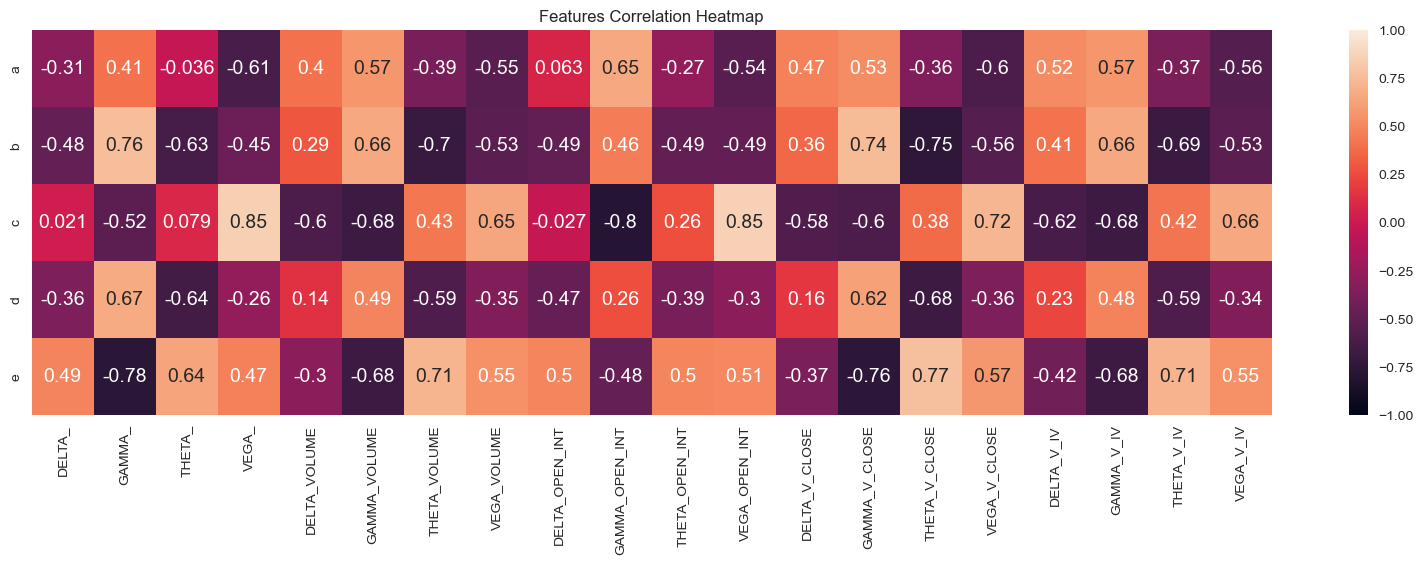

In [13]:
plt.figure(figsize=(20, 5))
heatmap1 = sns.heatmap(feat_corr.T, vmax=1, vmin=-1, annot=True)
heatmap1.set_title('Features Correlation Heatmap');